# Problématique 

Code permettant d'entrainer un modèle de reconnaissance text manuscrit.


# Import

In [43]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import re
from os.path import exists
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import string


import letter_detection_utils as ld_util
import preprocessing as pp
import ressources as rss
import modele as mdl
import rendering as rd


In [48]:
# Pour recharger les libs pendant les devs
from importlib import reload 
reload(ld_util)
reload(pp)
reload(rss)
reload(mdl)
reload(rd)

<module 'rendering' from '/Users/davidbeda/Python/Datascientest/projet_OCR_code/OCRpyMAN/notebooks/rendering.py'>

# Chargement du dataframe

In [49]:
# initialisation des variables globales
rss.init()

In [50]:
# Chargement avec tensorflow et dataset par batch

dataset_train, dataset_test, X_test, y_test = ld_util.get_dataset()

dataset_train_canny, dataset_test_canny, X_test_canny, y_test_canny = ld_util.get_dataset(canny=True)

/Users/davidbeda/Python/Datascientest/projet_OCR_code/OCRpyMAN/notebooks/letter_detection_utils.py:52: UserWarning: Creating resources inside a function passed to Dataset.map() is not supported. Create each resource outside the function, and capture it inside the function to use it.
  dataset_train = dataset_train.map(process_trancription)
/Users/davidbeda/Python/Datascientest/projet_OCR_code/OCRpyMAN/notebooks/letter_detection_utils.py:55: UserWarning: Creating resources inside a function passed to Dataset.map() is not supported. Create each resource outside the function, and capture it inside the function to use it.
  dataset_test = dataset_test.map(process_trancription)
/Users/davidbeda/Python/Datascientest/projet_OCR_code/OCRpyMAN/notebooks/letter_detection_utils.py:52: UserWarning: Creating resources inside a function passed to Dataset.map() is not supported. Create each resource outside the function, and capture it inside the function to use it.
  dataset_train = dataset_train.ma

In [51]:
# PROPOSITION DB : initialisation d'un iterator pour afficher différents batchs
batch_id=0
iterator = iter(dataset_train)

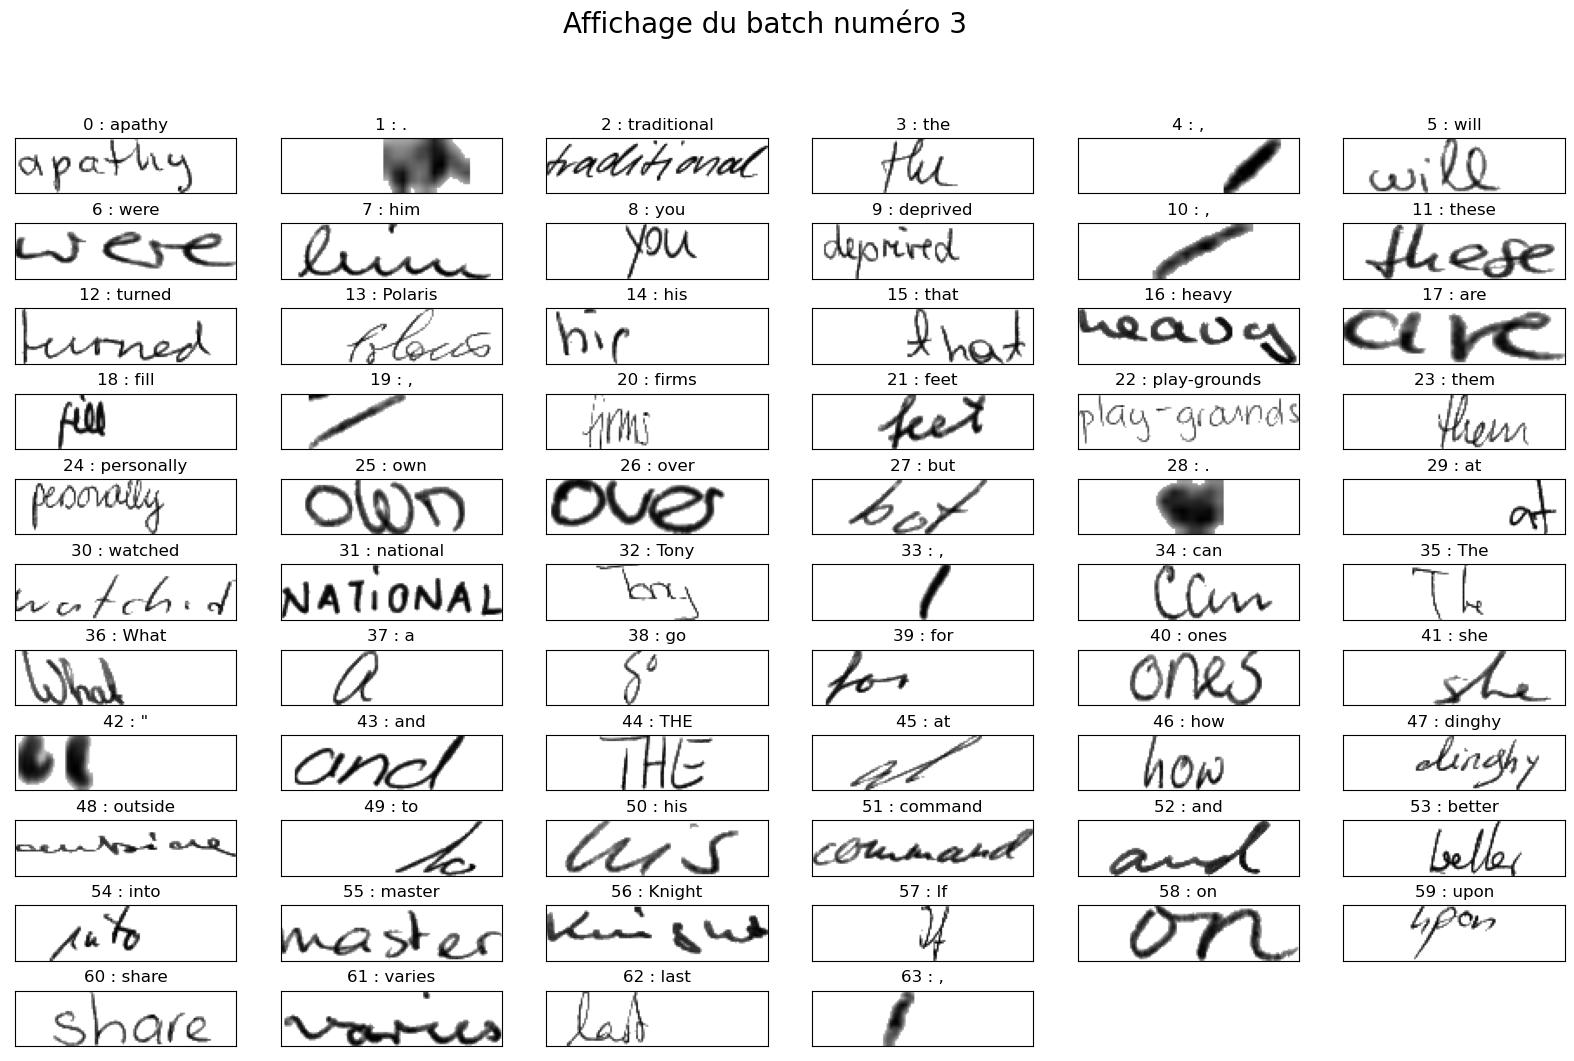

In [54]:
# PROPOSITION DB : lecture des 64 images d'un bacth (le prochain) du dataset d'entrainement

x,y = iterator.get_next()
batch_id +=1
rd.show_iterator_batch(x,y,batch_id)

# Model RNN

### Création Modèle

In [44]:
model = mdl.create_modele()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 128, 32)       832       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 128, 32)       128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 128, 32)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 64, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 64, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 64, 64)        0

In [46]:
class CTCLoss(tf.keras.losses.Loss):
    def __init__(self, logits_time_major=False, reduction=tf.keras.losses.Reduction.SUM, name='ctc'):
        super().__init__(reduction=reduction, name=name)
        self.logits_time_major = logits_time_major

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        logit_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        label_length = tf.fill([tf.shape(y_true)[0]], tf.shape(y_true)[1])
        loss = tf.nn.ctc_loss(
            labels=y_true,
            logits=y_pred,
            label_length=label_length,
            logit_length=logit_length,
            logits_time_major=self.logits_time_major,
            blank_index=-1)
        return tf.reduce_mean(loss)


early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=2,
)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='tmp_model', 
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch'
)

In [47]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss=CTCLoss(), optimizer=optimizer)
history = model.fit(
    dataset_train,
    validation_data=dataset_test,
    callbacks=[
        early_stop_callback,
        checkpoint_callback
    ],
    epochs=10
)

ValueError: Shape must be rank 4 but is rank 3 for 'loss_1/dense_loss/ctc_loss_dense/concat_1' (op: 'ConcatV2') with input shapes: [1,32,?,100], [32,?,?], [].

In [58]:
with open('history.pickle', 'wb') as file_pi:
     pickle.dump(history.history, file_pi)

with open('history.pickle', "rb") as file_pi:
    history = pickle.load(file_pi)

In [43]:
x, y = next(iter(dataset_train))
x.shape


TensorShape([64, 128, 32, 1])

In [59]:
y_pred = model.predict(dataset_test)


143/143 [==============================] - 89s 592ms/step


NameError: name 'utils' is not defined

In [72]:
predicted_transcriptions = ld_util.greedy_decoder(y_pred, rss.charList)
list(zip(predicted_transcriptions, y_test[:10]))

[('on', 'on'),
 ('masaly', 'conveniently'),
 ('it', 'not'),
 ('in', 'in'),
 ('He', 'He'),
 ('of', 'of'),
 (',', ','),
 ('is', 'is'),
 ('pust', 'just'),
 ('in', 'in')]